In [1]:
## standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os
os.makedirs("Data/", exist_ok=True)
import joblib
loaded_joblib  = joblib.load("saved_model.joblib")
loaded_joblib.keys()
import shap
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## set random state
SEED = 321
np.random.seed(SEED)
# set pandas to display more columns
pd.set_option('display.max_columns',50)

fpath=('zillow_home_values-zipcode.csv')
# read in data
df = pd.read_csv(fpath)

In [2]:
# define linreg function 
def evaluate_regression(model, X_train,y_train, X_test, y_test):    
    # Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
    # Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    
    
# define  coef grabber function
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    # Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [3]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [4]:
df.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,...,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,107274.0,107076.0,107081.0,107112.0,107325.0,107480.0,107709.0,108092.0,108328.0,108782.0,109187.0,109242.0,109045.0,108514.0,108330.0,...,204564.0,206902.0,209154.0,212069.0,213553.0,215782.0,218494.0,223994.0,229959.0,236318.0,241418.0,246015.0,249379.0,253321.0,257274.0,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,222885.0,223602.0,224818.0,224384.0,224051.0,222942.0,223281.0,222886.0,223553.0,224715.0,226127.0,226742.0,226052.0,225191.0,224344.0,...,346146.0,350598.0,354599.0,359133.0,364502.0,370992.0,377896.0,386576.0,397227.0,408018.0,417061.0,424951.0,431973.0,437659.0,443701.0,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,90009.0,90042.0,90007.0,90027.0,89987.0,89972.0,89926.0,89397.0,88767.0,87904.0,87765.0,87719.0,87845.0,87409.0,87119.0,...,144471.0,146280.0,147989.0,149669.0,151475.0,153251.0,155948.0,158804.0,161832.0,164617.0,167493.0,169790.0,171741.0,173354.0,175355.0,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,190588.0,192155.0,194686.0,196246.0,198131.0,200596.0,202906.0,205407.0,208731.0,212367.0,215368.0,217915.0,220488.0,223666.0,226950.0,...,583072.0,582981.0,580157.0,578240.0,577104.0,577493.0,579678.0,579581.0,579996.0,579154.0,580023.0,578203.0,576272.0,572245.0,570414.0,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,277855.0,279802.0,282271.0,283679.0,284880.0,285975.0,288330.0,290339.0,293681.0,296592.0,299017.0,300344.0,302885.0,307212.0,311950.0,...,712619.0,716779.0,721142.0,722880.0,723884.0,724676.0,730056.0,733300.0,735223.0,734912.0,738325.0,741995.0,745001.0,745550.0,748738.0,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [5]:
loaded_joblib.keys()

dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])

In [6]:
# Saving the train/test split data into individual variables
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test  = loaded_joblib['X_test']
y_test  = loaded_joblib['y_test']
#  Saving the models & preprocessor
rf_reg  = loaded_joblib['RandomForestRegressor']
lin_reg  = loaded_joblib['LinearRegression']

preprocessor = loaded_joblib['preprocessor']

In [7]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001EA7F9AC9D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001EA7F9ACD00>)],
                  verbose_feature_names_out=False)

In [8]:
X_train

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,TotRms AbvGrd,Land Contour
853,16269,NaN,5,907.0,Y,907,5,Lvl
1055,13891,107.0,5,1710.0,Y,1710,6,Lvl
2483,8900,NaN,4,1056.0,Y,1056,5,Lvl
2351,11475,85.0,6,713.0,Y,1552,6,Lvl
1700,13654,118.0,5,1704.0,Y,2758,9,Lvl
...,...,...,...,...,...,...,...,...
1425,11778,91.0,5,2271.0,Y,2276,7,Lvl
1833,10678,85.0,5,1683.0,Y,2872,9,Lvl
2847,10890,60.0,5,1058.0,Y,1551,6,Lvl
124,8800,80.0,7,936.0,Y,1054,6,Lvl


In [9]:
# fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()


X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(5)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
343,13860.0,75.000000,7.0,1952.0,2704.0,9.0,1.0,0.0,0.0,0.0,1.0
1413,8405.0,50.000000,8.0,861.0,1367.0,7.0,1.0,0.0,0.0,0.0,1.0
2583,11310.0,75.000000,5.0,1367.0,1375.0,5.0,1.0,0.0,0.0,0.0,1.0
2020,6180.0,60.000000,5.0,960.0,986.0,5.0,0.0,0.0,0.0,0.0,1.0
348,8530.0,69.230685,5.0,384.0,1474.0,7.0,1.0,0.0,0.0,0.0,1.0


In [10]:
# fit a linear regression model
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.66	RMSE= 47743.32
Test Data:	R^2= 0.66	RMSE= 42544.20


In [11]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Land Contour_Bnk   -72620.466486
Land Contour_Low   -43310.960673
Land Contour_Lvl   -42264.186316
TotRms AbvGrd       -6299.906977
Lot Area                0.107876
Total Bsmt SF          59.753976
Gr Liv Area           101.283754
Lot Frontage          109.311338
Overall Cond         1737.313325
Land Contour_HLS     4243.627305
Central Air_Y       31927.224382
dtype: float64

<Axes: title={'center': 'Top 3 Largest Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

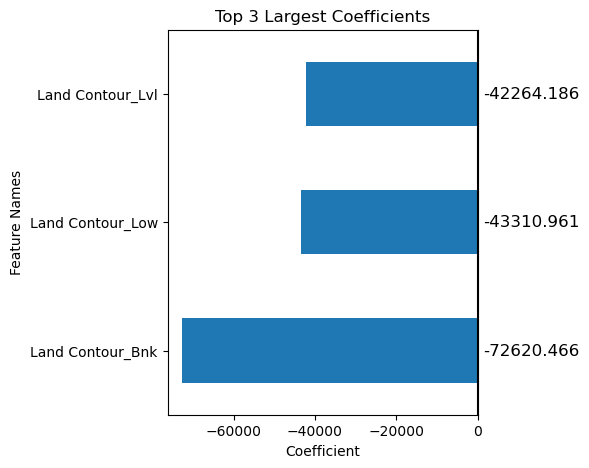

In [12]:
plot_coeffs(coeffs,top_n=3,annotate=True)

#### Our 3 Largest negative coefficients are our various land Contour levels and these features could impact Home Value depending on the location it is on. Being a bank seems to negatively impact our coefficient the most

<Axes: title={'center': 'Top -3 Largest Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

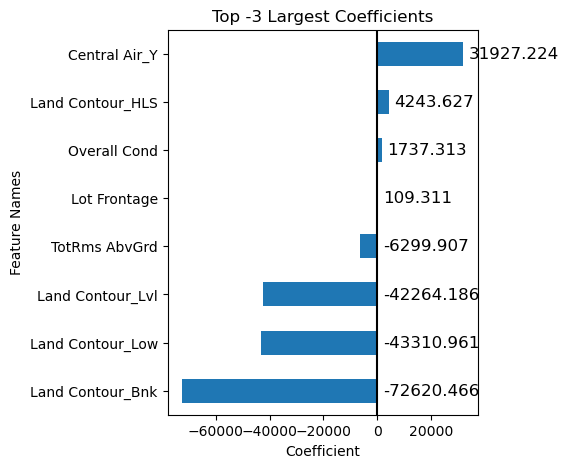

In [13]:
plot_coeffs(coeffs,top_n=-3,annotate=True)

#### Our three largest positive coefficients are Central Air_Y, Land Contour_HLS, and Overall Cond in that order. Having central AC is the largest positive coefficient in our group and will give us the best return.

In [14]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.97	RMSE= 14789.90
Test Data:	R^2= 0.78	RMSE= 34620.40


In [15]:
reg.feature_importances_

array([0.05251425, 0.04863555, 0.03290791, 0.36218039, 0.43733175,
       0.03398025, 0.01434964, 0.00626444, 0.00834711, 0.00050577,
       0.00298294])

In [16]:
## Check the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

11
11


True

In [17]:
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Lot Area            0.052514
Lot Frontage        0.048636
Overall Cond        0.032908
Total Bsmt SF       0.362180
Gr Liv Area         0.437332
TotRms AbvGrd       0.033980
Central Air_Y       0.014350
Land Contour_Bnk    0.006264
Land Contour_HLS    0.008347
Land Contour_Low    0.000506
Land Contour_Lvl    0.002983
Name: Feature Importance, dtype: float64

In [18]:
## Save the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Gr Liv Area         0.437332
Total Bsmt SF       0.362180
Lot Area            0.052514
Lot Frontage        0.048636
TotRms AbvGrd       0.033980
Overall Cond        0.032908
Central Air_Y       0.014350
Land Contour_HLS    0.008347
Land Contour_Bnk    0.006264
Land Contour_Lvl    0.002983
Land Contour_Low    0.000506
Name: Feature Importance, dtype: float64

<Axes: >

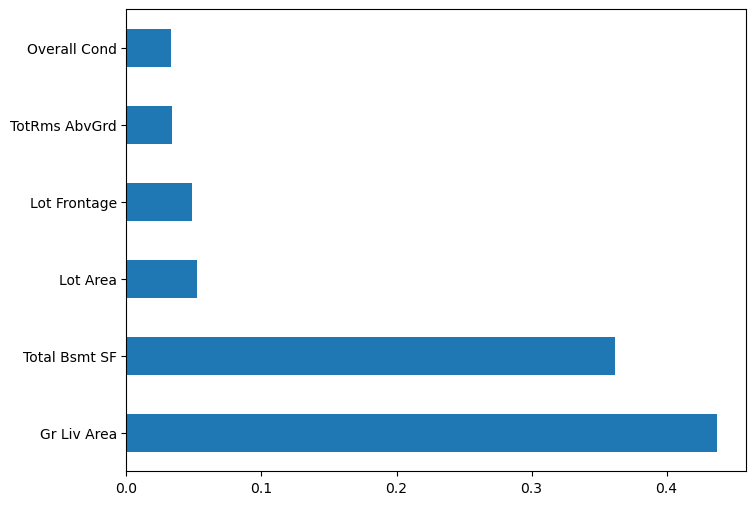

In [19]:
## find the top 6 importances and plot them
sorted_importance.head(6).plot(kind='barh',
                                   figsize=(8,6))

## Our 6 most important features are in order:

### 1. Gr Liv Area

### 2. Total Bsmt SF

### 3. Lot Area

### 4. Lot Frontage

### 5. TotRms AbvGrd

### 6. Overall Cond

## Overall Cond, TotRms AbvGrd, & Lot Frontage also make a return from our largest and smallest coefficients

In [20]:
shap.initjs()

In [21]:
# Create X_shap variable
X_shap = shap.sample(X_train_df, nsamples = 500, random_state = 321)
X_shap

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
297,19645.0,85.000000,6.0,423.0,1652.0,6.0,1.0,0.0,0.0,0.0,1.0
2846,8400.0,60.000000,5.0,940.0,1595.0,6.0,1.0,1.0,0.0,0.0,0.0
1319,5700.0,69.230685,7.0,572.0,1111.0,5.0,1.0,0.0,0.0,0.0,1.0
1570,164660.0,69.230685,6.0,1499.0,1786.0,7.0,1.0,0.0,1.0,0.0,0.0
1139,8453.0,65.000000,5.0,754.0,1609.0,6.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2498,14330.0,100.000000,4.0,1748.0,2646.0,9.0,1.0,0.0,0.0,1.0,0.0
2357,10140.0,78.000000,6.0,1040.0,1309.0,5.0,1.0,0.0,0.0,0.0,1.0
564,11949.0,69.230685,8.0,975.0,1755.0,7.0,1.0,0.0,0.0,0.0,1.0
2282,32463.0,69.230685,4.0,1249.0,1622.0,7.0,1.0,0.0,0.0,1.0,0.0


In [22]:
# Create y_shap variable
y_shap = y_train.loc[X_shap.index].astype(int)
y_shap

297     203135
2846    140000
1319    116900
1570    228950
1139    182000
         ...  
2498    260000
2357    181000
564     235000
2282    168000
2080    118000
Name: SalePrice, Length: 500, dtype: int32

In [23]:
# Reset index values
X_shap = X_shap.reset_index(drop=True)
y_shap = y_shap.reset_index(drop=True)
X_shap

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
0,19645.0,85.000000,6.0,423.0,1652.0,6.0,1.0,0.0,0.0,0.0,1.0
1,8400.0,60.000000,5.0,940.0,1595.0,6.0,1.0,1.0,0.0,0.0,0.0
2,5700.0,69.230685,7.0,572.0,1111.0,5.0,1.0,0.0,0.0,0.0,1.0
3,164660.0,69.230685,6.0,1499.0,1786.0,7.0,1.0,0.0,1.0,0.0,0.0
4,8453.0,65.000000,5.0,754.0,1609.0,6.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
495,14330.0,100.000000,4.0,1748.0,2646.0,9.0,1.0,0.0,0.0,1.0,0.0
496,10140.0,78.000000,6.0,1040.0,1309.0,5.0,1.0,0.0,0.0,0.0,1.0
497,11949.0,69.230685,8.0,975.0,1755.0,7.0,1.0,0.0,0.0,0.0,1.0
498,32463.0,69.230685,4.0,1249.0,1622.0,7.0,1.0,0.0,0.0,1.0,0.0


In [24]:
# Create model explainer
explainer = shap.Explainer(rf_reg)
explainer

In [25]:
# Getting the shap values
shap_values = explainer(X_shap, y_shap)
type(shap_values)

shap._explanation.Explanation

In [26]:
# Confirm shap values are 2 dimension
shap_values.shape

(500, 11)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


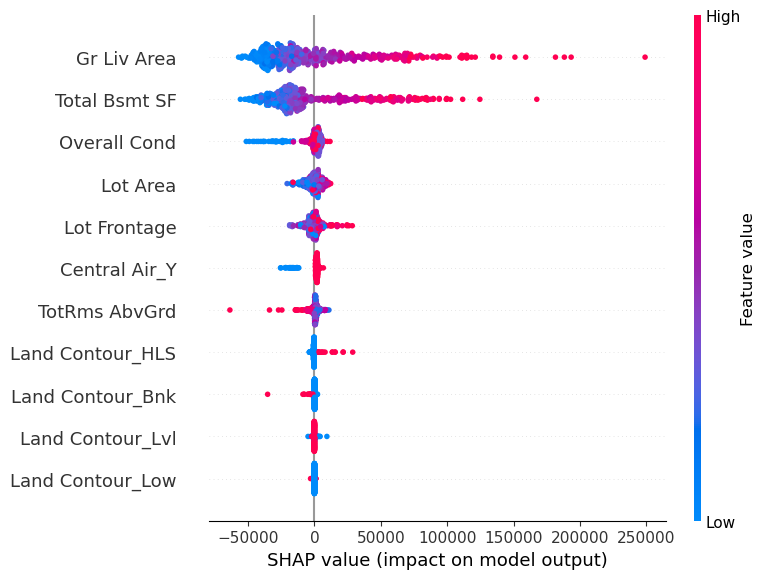

In [27]:
# Create summary plot with plot_type='bar'
fig, ax = plt.subplots()
shap.summary_plot(shap_values,features= X_shap, plot_type='dot')


## Interpret the top 6 most important features. According to shap, what effect does each feature have on the model’s prediction?

### 1. Gr Liv Area has a substantial negative lean on it's impact but also displays the most varied positively impactful outliers out of any other feature

### 2.Total Bsmt SF has a negative lean on it's impact same as Gr Liv Area but less postively impactful outliers

### 3. Overall cond sits largely nuetral but with a moderate~strong amount of negatively impactful outliers

### 4. Lot area is probably our most congrested and mostly nuetral model with no substantial outliers

### 5.Lot frontage has a lot of positive outliers with a lot of nuetral impact

### 6. Central Air has a strong positive presence with a few outliers with a negative impact on model output

In [28]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,...,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,107274.0,107076.0,107081.0,107112.0,107325.0,107480.0,107709.0,108092.0,108328.0,108782.0,109187.0,109242.0,109045.0,108514.0,108330.0,...,204564.0,206902.0,209154.0,212069.0,213553.0,215782.0,218494.0,223994.0,229959.0,236318.0,241418.0,246015.0,249379.0,253321.0,257274.0,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,222885.0,223602.0,224818.0,224384.0,224051.0,222942.0,223281.0,222886.0,223553.0,224715.0,226127.0,226742.0,226052.0,225191.0,224344.0,...,346146.0,350598.0,354599.0,359133.0,364502.0,370992.0,377896.0,386576.0,397227.0,408018.0,417061.0,424951.0,431973.0,437659.0,443701.0,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,90009.0,90042.0,90007.0,90027.0,89987.0,89972.0,89926.0,89397.0,88767.0,87904.0,87765.0,87719.0,87845.0,87409.0,87119.0,...,144471.0,146280.0,147989.0,149669.0,151475.0,153251.0,155948.0,158804.0,161832.0,164617.0,167493.0,169790.0,171741.0,173354.0,175355.0,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,190588.0,192155.0,194686.0,196246.0,198131.0,200596.0,202906.0,205407.0,208731.0,212367.0,215368.0,217915.0,220488.0,223666.0,226950.0,...,583072.0,582981.0,580157.0,578240.0,577104.0,577493.0,579678.0,579581.0,579996.0,579154.0,580023.0,578203.0,576272.0,572245.0,570414.0,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,277855.0,279802.0,282271.0,283679.0,284880.0,285975.0,288330.0,290339.0,293681.0,296592.0,299017.0,300344.0,302885.0,307212.0,311950.0,...,712619.0,716779.0,721142.0,722880.0,723884.0,724676.0,730056.0,733300.0,735223.0,734912.0,738325.0,741995.0,745001.0,745550.0,748738.0,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [29]:
# Melt the data
df= pd.melt(df,id_vars=[ 'RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State','City', 'Metro','CountyName' ] 
                ,var_name = "Date", value_name = "Home Value")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionID    int64  
 1   SizeRank    int64  
 2   RegionName  int64  
 3   RegionType  object 
 4   StateName   object 
 5   State       object 
 6   City        object 
 7   Metro       object 
 8   CountyName  object 
 9   Date        object 
 10  Home Value  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 633.3+ MB


In [30]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0


In [31]:
# Convert the melted dates into datetime datatype.
# Add a datetime column based on the string in the "date" column
df['datetime'] = pd.to_datetime(df['Date'], format = '%d%m%Y')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   SizeRank    int64         
 2   RegionName  int64         
 3   RegionType  object        
 4   StateName   object        
 5   State       object        
 6   City        object        
 7   Metro       object        
 8   CountyName  object        
 9   Date        object        
 10  Home Value  float64       
 11  datetime    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 690.9+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value,datetime
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0,2000-01-31
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0,2000-01-31
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0,2000-01-31
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0,2000-01-31
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0,2000-01-31


In [32]:
# Set the date column as the index
df = df.set_index('datetime')
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
datetime,,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,110082.0


In [33]:
# Filter out the requried data

df = df.loc[(df.index.year>=2010) & (df.index.year<=2020) & (df['State'].isin(  ['CA', 'WA', 'OR', 
                      'AZ', 'NV']))]
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
datetime,,,,,,,,,,,
2010-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012010,209250.0
2010-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012010,257372.0
2010-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012010,296430.0
2010-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,31012010,271829.0
2010-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,31012010,156704.0


In [34]:
## Save current dataframe to file.
df.to_csv("Data/data-for-tableau.csv")

In [35]:
df_group = df.groupby('State').resample("Y").mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will

In [36]:
df_group

RegionID      SizeRank    RegionName     Home Value
State datetime                                                            
AZ    2010-12-31  125430.669782   9836.641745  85550.336449  169930.889076
      2011-12-31  125430.669782   9836.641745  85550.336449  152272.467002
      2012-12-31  125430.669782   9836.641745  85550.336449  159902.057789
      2013-12-31  125430.669782   9836.641745  85550.336449  183657.225403
      2014-12-31  125430.669782   9836.641745  85550.336449  198551.492521
      2015-12-31  125430.669782   9836.641745  85550.336449  206834.173937
      2016-12-31  125430.669782   9836.641745  85550.336449  217452.799614
      2017-12-31  125430.669782   9836.641745  85550.336449  229066.028099
      2018-12-31  125430.669782   9836.641745  85550.336449  244689.172792
      2019-12-31  125430.669782   9836.641745  85550.336449  257396.582183
      2020-12-31  125430.669782   9836.641745  85550.336449  278841.942045
CA    2010-12-31   98747.743802   9324.490782  93598.652893  415491.808100
      2011-12-31   98747.743802   9324.490782  93598.652893  388468.031550
      2012-12-31   98747.743802   9324.490782  93598.652893  388593.634299
      2013-12-31   98747.743802   9324.490782  93598.652893  454509.845597
      2014-12-31   98747.743802   9324.490782  93598.652893  505808.423831
      2015-12-31   98747.743802   9324.490782  93598.652893  535297.119658
      2016-12-31   98747.743802   9324.490782  93598.652893  569319.272450
      2017-12-31   98747.743802   9324.490782  93598.652893  601938.428066
      2018-12-31   98747.743802   9324.490782  93598.652893  646936.553061
      2019-12-31   98747.743802   9324.490782  93598.652893  649531.475923
      2020-12-31   98747.743802   9324.490782  93598.652893  675124.170696
NV    2010-12-31  112977.664336  10727.580420  89265.237762  189285.319787
      2011-12-31  112977.664336  10727.580420  89265.237762  168931.537037
      2012-12-31  112977.664336  10727.580420  89265.237762  165003.293888
      2013-12-31  112977.664336  10727.580420  89265.237762  199847.532946
      2014-12-31  112977.664336  10727.580420  89265.237762  228975.139535
      2015-12-31  112977.664336  10727.580420  89265.237762  247372.119614
      2016-12-31  112977.664336  10727.580420  89265.237762  265123.976834
      2017-12-31  112977.664336  10727.580420  89265.237762  284543.217949
      2018-12-31  112977.664336  10727.580420  89265.237762  319753.462629
      2019-12-31  112977.664336  10727.580420  89265.237762  337914.425207
      2020-12-31  112977.664336  10727.580420  89265.237762  350564.885423
OR    2010-12-31  106076.819178  14728.101370  97394.490411  224035.019849
      2011-12-31  106076.819178  14728.101370  97394.490411  205273.042225
      2012-12-31  106076.819178  14728.101370  97394.490411  201899.022119
      2013-12-31  106076.819178  14728.101370  97394.490411  216964.502931
      2014-12-31  106076.819178  14728.101370  97394.490411  233022.531108
      2015-12-31  106076.819178  14728.101370  97394.490411  249633.916898
      2016-12-31  106076.819178  14728.101370  97394.490411  272424.454568
      2017-12-31  106076.819178  14728.101370  97394.490411  294524.759060
      2018-12-31  106076.819178  14728.101370  97394.490411  311491.056020
      2019-12-31  106076.819178  14728.101370  97394.490411  323800.937928
      2020-12-31  106076.819178  14728.101370  97394.490411  338782.970027
WA    2010-12-31   99857.935728  13383.391304  98603.703214  250932.487018
      2011-12-31   99857.935728  13383.391304  98603.703214  230557.026098
      2012-12-31   99857.935728  13383.391304  98603.703214  225432.142832
      2013-12-31   99857.935728  13383.391304  98603.703214  240848.444598
      2014-12-31   99857.935728  13383.391304  98603.703214  256869.916239
      2015-12-31   99857.935728  13383.391304  98603.703214  275704.942220
      2016-12-31   99857.935728  13383.391304  98603.703214  302116.532078
      2017-12-31   99857.935728  13383.391304  9

In [37]:
#Unstack cities in df_ts
unstacked = df_group.unstack(level = 0)
unstacked

RegionID                                              \
State                  AZ            CA             NV             OR   
datetime                                                                
2010-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2011-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2012-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2013-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2014-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2015-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2016-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2017-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2018-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2019-12-31  125430.669782  98747.743802  112977.664336  106076.819178   
2020-12-31  125430.669782  98747.743802  112977.664336  106076.819178   

                             SizeRank                                         \
State                 WA           AZ           CA           NV           OR   
datetime                                                                       
2010-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2011-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2012-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2013-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2014-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2015-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2016-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2017-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2018-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2019-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   
2020-12-31  99857.935728  9836.641745  9324.490782  10727.58042  14728.10137   

                            RegionName                              \
State                 WA            AZ            CA            NV   
datetime                                                             
2010-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2011-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2012-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2013-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2014-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2015-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2016-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2017-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2018-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2019-12-31  13383.391304  85550.336449  93598.652893  89265.237762   
2020-12-31  13383.391304  85550.336449  93598.652893  89265.237762   

                                           Home Value                 \
State                 OR            WA             AZ             CA   
datetime                                                               
2010-12-31  97394.490411  98603.703214  169930.889076  415491.808100   
2011-12-31  97394.490411  98603.703214  152272.467002  388468.031550   
2012-12-31  97394.490411  98603.703214  159902.057789  388593.634299   
2013-12-31  97394.490411  98603.703214  183657.225403  454509.845597   
2014-12-31  97394.490411  98603.703214  198551.492521  505808.423831   
2015-12-31  97394.490411  98603.703214  206834.173937  535297.119658   
2016-12-31  97394.490411  98603.703214  217452.799614  569319.272450   
2017-12-31  97394.490411  98603.703214  229066.028099  601938.428066   
2018-12-31  97394.490411  98603.703214  244689.172792  646936.553061   
2019-12-31  97394.490411  98

In [38]:
#Function for string formatter
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_thous = mticks.FuncFormatter(thousands)

[Text(0.5, 1.0, 'House Prices by City'), Text(0, 0.5, 'Price ($K)')]

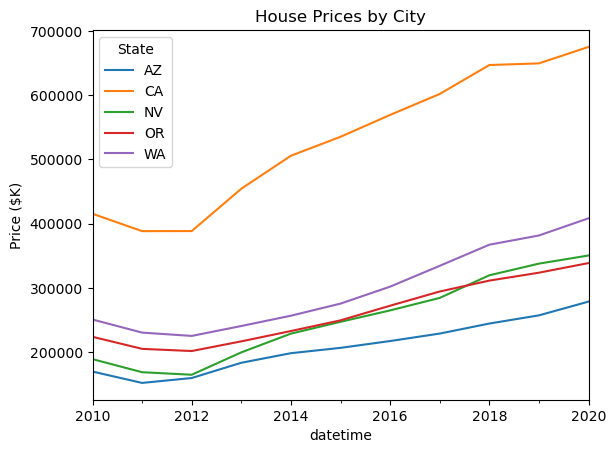

In [39]:
# Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.
#Plot the data
ax = unstacked['Home Value'].plot()
ax.set(title = 'House Prices by City', ylabel = 'Price ($K)')